In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    train_test_split
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    roc_auc_score,
    recall_score,
    f1_score,
    accuracy_score,
    precision_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    roc_curve
)


In [3]:
# Leer data
student_info = pd.read_csv('/content/drive/MyDrive/IA_APLICADA/PROYECTO_IA/DATA/anonymisedData/studentInfo.csv')
student_reg = pd.read_csv('/content/drive/MyDrive/IA_APLICADA/PROYECTO_IA/DATA/anonymisedData/studentRegistration.csv')
student_assess = pd.read_csv('/content/drive/MyDrive/IA_APLICADA/PROYECTO_IA/DATA/anonymisedData/studentAssessment.csv')
assessments = pd.read_csv('/content/drive/MyDrive/IA_APLICADA/PROYECTO_IA/DATA/anonymisedData/assessments.csv')
student_vle = pd.read_csv('/content/drive/MyDrive/IA_APLICADA/PROYECTO_IA/DATA/anonymisedData/studentVle.csv')
vle = pd.read_csv('/content/drive/MyDrive/IA_APLICADA/PROYECTO_IA/DATA/anonymisedData/vle.csv')
courses = pd.read_csv('/content/drive/MyDrive/IA_APLICADA/PROYECTO_IA/DATA/anonymisedData/courses.csv')


In [4]:
for name, df_aux in [
    ("student_info", student_info),
    ("student_reg", student_reg),
    ("student_assess", student_assess),
    ("assessments", assessments),
    ("student_vle", student_vle),
    ("vle", vle),
    ("courses", courses),
]:
    print(name, df_aux.shape)

student_info (32593, 12)
student_reg (32593, 5)
student_assess (173912, 5)
assessments (206, 6)
student_vle (10655280, 6)
vle (6364, 6)
courses (22, 3)


In [5]:
# Día límite para predicción temprana
DAY_CUTOFF = 90
print("Usando día de corte:", DAY_CUTOFF)

Usando día de corte: 90


In [6]:
# Copia del dataframe principal
df = student_info.copy()

# Etiqueta binaria: abandono del curso
df['dropout'] = (df['final_result'] == 'Withdrawn').astype(int)

# Variables que vamos a conservar
df = df[['code_module', 'code_presentation', 'id_student',
         'gender', 'region', 'highest_education',
         'imd_band', 'age_band', 'num_of_prev_attempts',
         'studied_credits', 'disability', 'dropout']]

df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,dropout
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,1
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,0


In [7]:
reg = student_reg.copy()

reg['days_enrolled_until_90'] = DAY_CUTOFF - reg['date_registration']
reg['days_enrolled_until_90'] = reg['days_enrolled_until_90'].clip(lower=0)

reg['unreg_before_90'] = (
    reg['date_unregistration'].notna() &
    (reg['date_unregistration'] <= DAY_CUTOFF)
).astype(int)

reg_features = reg[['code_module', 'code_presentation', 'id_student',
                    'days_enrolled_until_90', 'unreg_before_90']]

reg_features.head()

,code_module,code_presentation,id_student,days_enrolled_until_90,unreg_before_90
0,AAA,2013J,11391,249.0,0
1,AAA,2013J,28400,143.0,0
2,AAA,2013J,30268,182.0,1
3,AAA,2013J,31604,142.0,0
4,AAA,2013J,32885,266.0,0


In [8]:
assess = assessments.copy()
sa = student_assess.copy()

# Evaluaciones hasta el día de corte
assess_early = assess[assess['date'] <= DAY_CUTOFF]

# Entregas tempranas
sa_early = sa.merge(
    assess_early[['id_assessment', 'code_module', 'code_presentation', 'date']],
    on='id_assessment',
    how='inner'
)

# Agrupación por alumno-curso
agg_sa = sa_early.groupby(['code_module', 'code_presentation', 'id_student']).agg(
    n_assess_submitted_early=('id_assessment', 'nunique'),
    mean_score_early=('score', 'mean')
).reset_index()

# Total de evaluaciones tempranas del curso
assess_early_course = assess_early.groupby(
    ['code_module', 'code_presentation']
).agg(
    n_assess_early_total=('id_assessment', 'nunique')
).reset_index()

# Merge para calcular "no entregado"
agg_sa = agg_sa.merge(
    assess_early_course,
    on=['code_module', 'code_presentation'],
    how='left'
)

agg_sa['n_assess_not_submitted_early'] = (
    agg_sa['n_assess_early_total'] - agg_sa['n_assess_submitted_early']
)

# Resultado final de features de evaluaciones
eval_features = agg_sa[['code_module', 'code_presentation', 'id_student',
                        'n_assess_submitted_early', 'mean_score_early',
                        'n_assess_not_submitted_early']]

eval_features.head()

,code_module,code_presentation,id_student,n_assess_submitted_early,mean_score_early,n_assess_not_submitted_early
0,AAA,2013J,11391,2,81.5,0
1,AAA,2013J,28400,2,69.0,0
2,AAA,2013J,31604,2,71.5,0
3,AAA,2013J,32885,2,49.5,0
4,AAA,2013J,38053,2,74.0,0


In [9]:
sv = student_vle.copy()
vle_meta = vle.copy()

# Filtrar por día de corte
sv_early = sv[sv['date'] <= DAY_CUTOFF]

# Añadir tipo de recurso
sv_early = sv_early.merge(
    vle_meta[['id_site', 'activity_type']],
    on='id_site',
    how='left'
)

# Clics totales + días activos
agg_clicks = sv_early.groupby(
    ['code_module', 'code_presentation', 'id_student']
).agg(
    total_clicks_0_90=('sum_click', 'sum'),
    active_days_0_90=('date', 'nunique')
).reset_index()

# Clics por tipo de actividad
clicks_by_type = sv_early.groupby(
    ['code_module', 'code_presentation', 'id_student', 'activity_type']
)['sum_click'].sum().unstack(fill_value=0).reset_index()

# Merge final
vle_features = agg_clicks.merge(
    clicks_by_type,
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)

vle_features.head()

,code_module,code_presentation,id_student,total_clicks_0_90,active_days_0_90,dataplus,dualpane,externalquiz,forumng,glossary,...,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,AAA,2013J,11391,587,23,0,0,0,126,0,...,0,0,0,0,0,0,9,0,23,1
1,AAA,2013J,28400,821,36,0,0,0,283,0,...,0,0,0,0,0,0,5,0,63,35
2,AAA,2013J,30268,281,12,0,0,0,126,0,...,0,0,0,0,0,0,4,0,22,4
3,AAA,2013J,31604,992,51,0,0,0,260,1,...,0,0,0,0,0,0,10,0,81,40
4,AAA,2013J,32885,684,35,0,0,0,160,2,...,0,0,0,0,0,0,7,0,33,6


In [10]:
features = df.copy()

# Merge con registro
features = features.merge(
    reg_features,
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)

# Merge con evaluaciones
features = features.merge(
    eval_features,
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)

# Merge con VLE
features = features.merge(
    vle_features,
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)

features.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,23.0,1.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,63.0,35.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,81.0,40.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,33.0,6.0


In [11]:
# Evaluaciones tempranas
features['n_assess_submitted_early']      = features['n_assess_submitted_early'].fillna(0)
features['n_assess_not_submitted_early']  = features['n_assess_not_submitted_early'].fillna(0)
features['mean_score_early']              = features['mean_score_early'].fillna(0)

# Actividad VLE
features['total_clicks_0_90'] = features['total_clicks_0_90'].fillna(0)
features['active_days_0_90']  = features['active_days_0_90'].fillna(0)

# Columnas dinámicas de "activity_type"
activity_cols = [
    c for c in features.columns
    if c not in df.columns and c not in [
        'days_enrolled_until_90', 'unreg_before_90',
        'n_assess_submitted_early', 'mean_score_early',
        'n_assess_not_submitted_early',
        'total_clicks_0_90', 'active_days_0_90'
    ]
]

for c in activity_cols:
    features[c] = features[c].fillna(0)

# imd_band categórica
features['imd_band'] = features['imd_band'].fillna('Unknown')

# Si falta registro de matrícula → 0 días
features['days_enrolled_until_90'] = features['days_enrolled_until_90'].fillna(0)

print("NaNs totales en features:", features.isna().sum().sum())
print(features.shape)


NaNs totales en features: 0
(32593, 38)


In [12]:
features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   code_module                   32593 non-null  object 
 1   code_presentation             32593 non-null  object 
 2   id_student                    32593 non-null  int64  
 3   gender                        32593 non-null  object 
 4   region                        32593 non-null  object 
 5   highest_education             32593 non-null  object 
 6   imd_band                      32593 non-null  object 
 7   age_band                      32593 non-null  object 
 8   num_of_prev_attempts          32593 non-null  int64  
 9   studied_credits               32593 non-null  int64  
 10  disability                    32593 non-null  object 
 11  dropout                       32593 non-null  int64  
 12  days_enrolled_until_90        32593 non-null  float64
 13  u

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,23.0,1.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,63.0,35.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,81.0,40.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,33.0,6.0


In [13]:
# Separar X (features) e y (etiqueta)
# Etiqueta: abandono del curso
y = features['dropout']

# Features: todo menos la etiqueta y el id del estudiante
X = features.drop(columns=['dropout', 'id_student'])

print("Shape X:", X.shape)
print("Shape y:", y.shape)

# Train/Test Split (80% / 20%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test:",  X_test.shape, y_test.shape)

Shape X: (32593, 36)
Shape y: (32593,)
Train: (26074, 36) (26074,)
Test: (6519, 36) (6519,)


In [14]:
features.to_csv(
    '/content/drive/MyDrive/IA_APLICADA/PROYECTO_IA/DATA/features.csv',
    index=False
)


In [15]:
!ls /content/drive/MyDrive/IA_APLICADA/PROYECTO_IA/DATA


anonymisedData	features.csv


In [ ]:
# Definir columnas categóricas y numéricas
cat_cols = [
    'code_module',
    'code_presentation',
    'gender',
    'region',
    'highest_education',
    'imd_band',
    'age_band',
    'disability'
]

num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categóricas:", cat_cols)
print("N° columnas numéricas:", len(num_cols))

# Preprocesamiento: OneHot + StandardScaler
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

Categóricas: ['code_module', 'code_presentation', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability']
N° columnas numéricas: 28


In [ ]:
# Definir modelos a comparar
models = {
    'log_reg': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'tree':    DecisionTreeClassifier(max_depth=5, class_weight='balanced'),
    'knn':     KNeighborsClassifier(n_neighbors=15)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', model)
    ])

    scores = cross_validate(
        pipe, X_train, y_train,
        cv=cv,
        scoring=['roc_auc', 'recall', 'f1'],
        return_train_score=False
    )

    results[name] = {
        'roc_auc_mean': scores['test_roc_auc'].mean(),
        'recall_mean':  scores['test_recall'].mean(),
        'f1_mean':      scores['test_f1'].mean()
    }

results_df = pd.DataFrame(results).T.round(3)
results_df


,roc_auc_mean,recall_mean,f1_mean
log_reg,0.908,0.734,0.807
tree,0.906,0.730,0.803
knn,0.886,0.678,0.804


In [ ]:
# Entrenar modelo final y evaluar en TEST
best_model = LogisticRegression(max_iter=1000, class_weight='balanced')

pipe_best = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', best_model)
])

# Entrenar en TODO el conjunto de entrenamiento
pipe_best.fit(X_train, y_train)

# Predicciones (en TEST)
y_test_pred  = pipe_best.predict(X_test)
y_test_proba = pipe_best.predict_proba(X_test)[:, 1]  # prob. de abandono

# Métricas en TEST
acc  = accuracy_score(y_test, y_test_pred)
rec  = recall_score(y_test, y_test_pred)
f1   = f1_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
auc  = roc_auc_score(y_test, y_test_proba)

print(f"Accuracy (TEST):  {acc:.3f}")
print(f"Recall (TEST):    {rec:.3f}")
print(f"F1-score (TEST):  {f1:.3f}")
print(f"Precision (TEST): {prec:.3f}")
print(f"AUC (TEST):       {auc:.3f}")

print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_test_pred, digits=3))


Accuracy (TEST):  0.898
Recall (TEST):    0.743
F1-score (TEST):  0.819
Precision (TEST): 0.911
AUC (TEST):       0.917

Reporte de clasificación:

              precision    recall  f1-score   support

           0      0.893     0.967     0.929      4488
           1      0.911     0.743     0.819      2031

    accuracy                          0.898      6519
   macro avg      0.902     0.855     0.874      6519
weighted avg      0.899     0.898     0.894      6519



<Figure size 500x500 with 0 Axes>

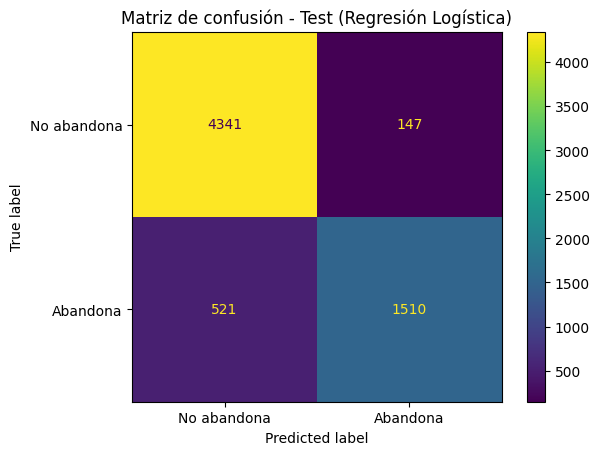

In [ ]:
# Matriz de Confusión en TEST
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No abandona', 'Abandona'])

plt.figure(figsize=(5, 5))
disp.plot(values_format='d')
plt.title("Matriz de confusión - Test (Regresión Logística)")
plt.show()


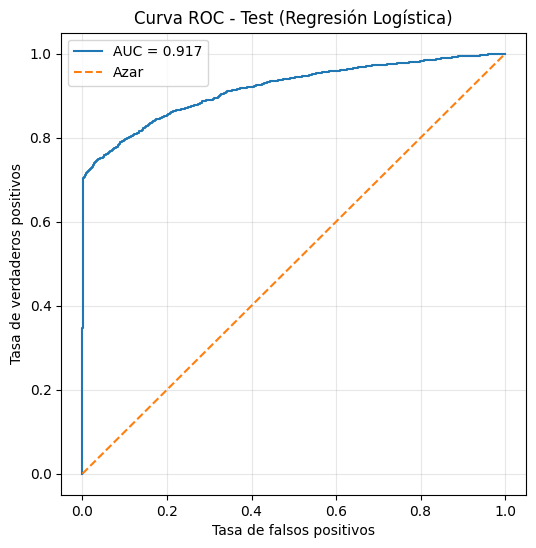

In [ ]:
# Curva ROC en TEST
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', label="Azar")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC - Test (Regresión Logística)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Usando un corte de día 90, el modelo logró un accuracy de 89.8% en el conjunto de prueba (n=6519). Detectó correctamente 1510 de los 2031 estudiantes que abandonan (recall = 74.3%) y clasificó correctamente a 4341 de los 4488 que no abandonan. En total, el sistema acierta en 5851 predicciones y falla en 668. Estos resultados muestran un desempeño robusto para una tarea de alerta temprana en educación. Se puede mejorar